Identified 8 categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Identified 8 numerical columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Classes mapping: {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}

Target Variable Distribution:
2    351
4    324
3    297
5    290
6    290
1    287
0    272
Name: count, dtype: int64


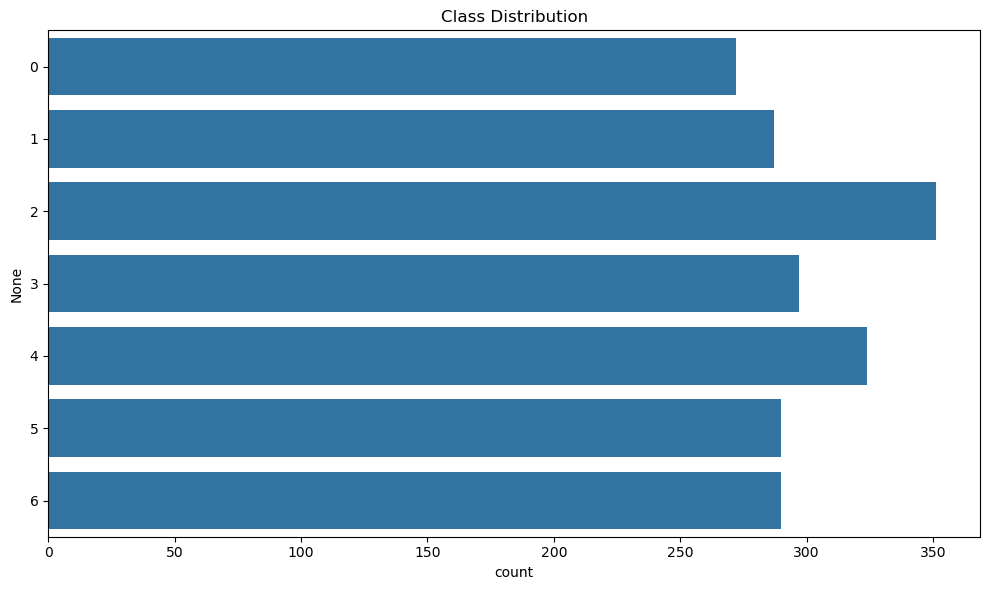

Dataset shape after one-hot encoding: (2111, 23)
Training set: (1688, 23), Test set: (423, 23)

=== Feature Selection using Random Forest ===

Top 15 features by importance:
Weight: 0.2984
Height: 0.0914
Age: 0.0914
FCVC: 0.0895
Gender_Male: 0.0584
NCP: 0.0521
CH2O: 0.0508
FAF: 0.0498
TUE: 0.0487
family_history_with_overweight_yes: 0.0296
CALC_Sometimes: 0.0214
CAEC_Frequently: 0.0201
CAEC_Sometimes: 0.0193
FAVC_yes: 0.0189
MTRANS_Public_Transportation: 0.0186


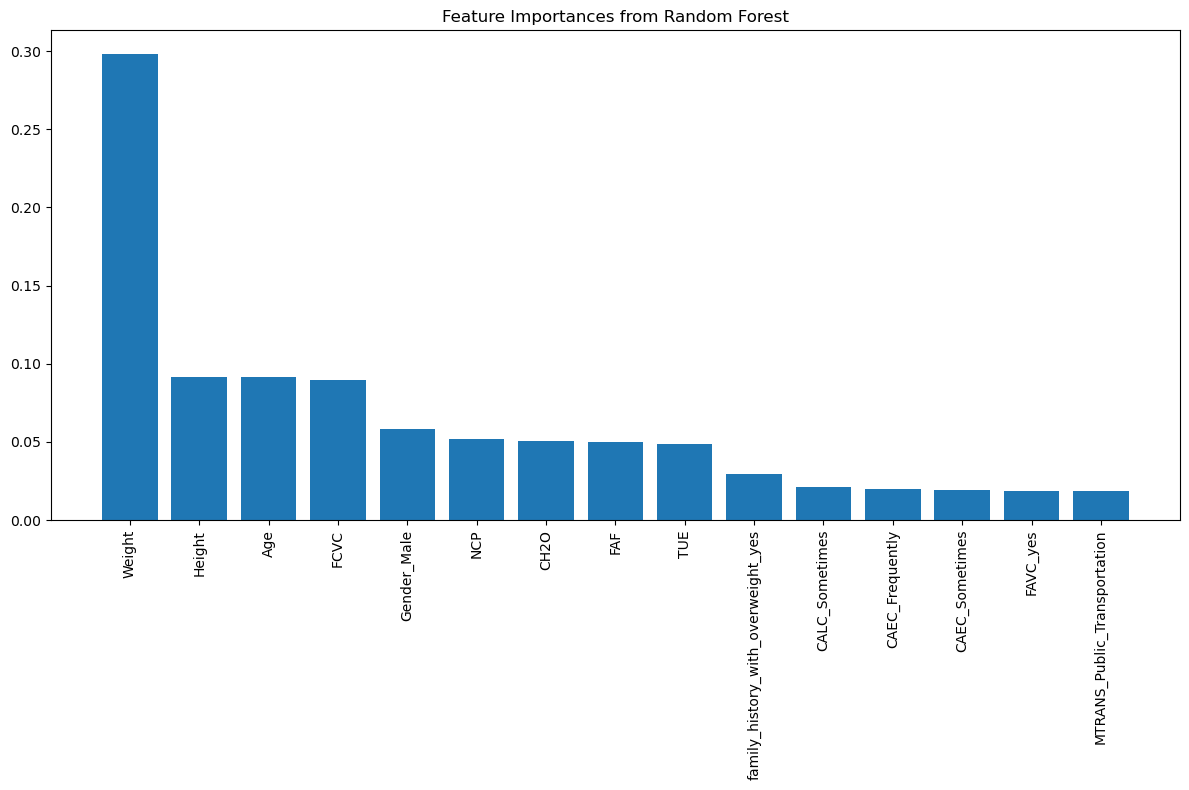


Number of features selected: 9 out of 23
Selected features: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Gender_Male']

Feature matrix shapes after selection: Train (1688, 9), Test (423, 9)

=== Model Evaluation with All Features ===

Training Logistic Regression with all features...
CV scores: [0.86390533 0.9112426  0.87278107 0.87240356 0.88724036]
Mean CV score: 0.8815
Test accuracy: 0.8794
Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        54
           1       0.83      0.76      0.79        58
           2       0.88      0.93      0.90        70
           3       0.95      0.97      0.96        60
           4       1.00      0.98      0.99        65
           5       0.74      0.74      0.74        58
           6       0.80      0.76      0.78        58

    accuracy                           0.88       423
   macro avg       0.88      0.88      0.88       423
weighted avg    

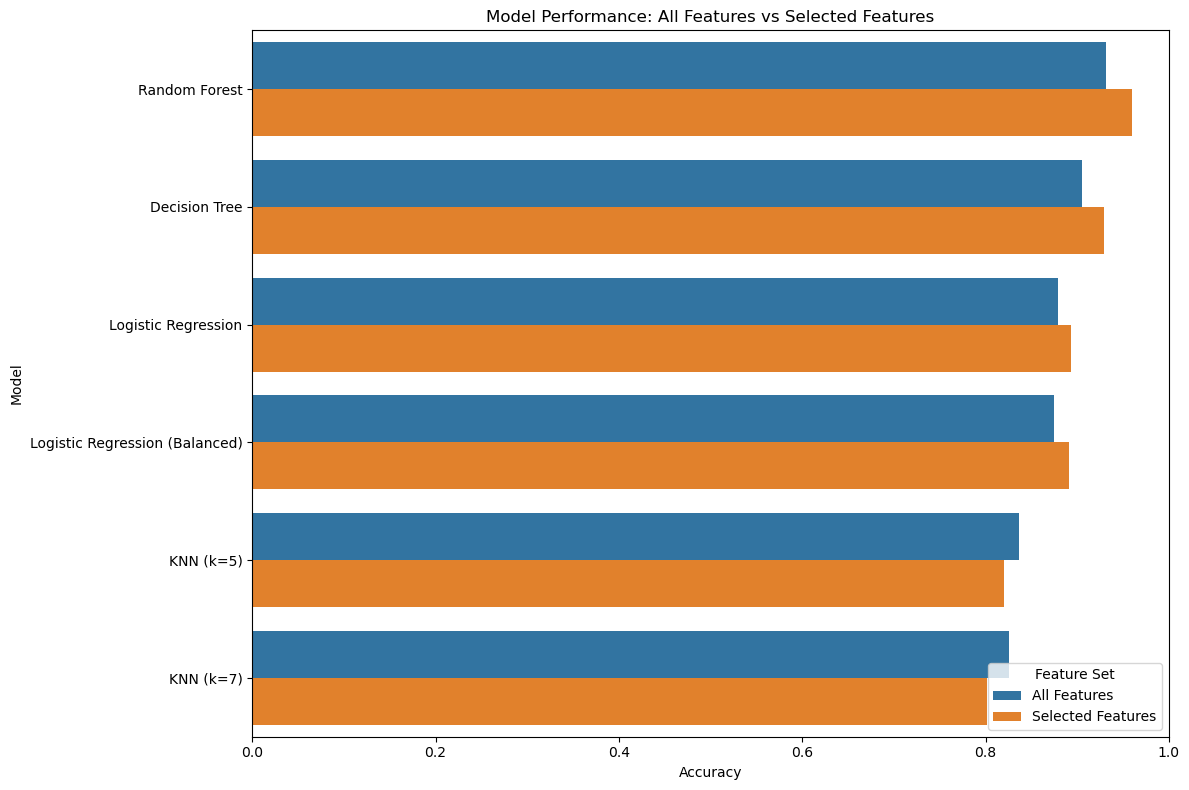


Best model after feature selection: Random Forest with accuracy 0.9598

Feature selection modeling completed. Next steps could include:
1. Hyperparameter tuning for the best model
2. Try different feature selection thresholds
3. Try other feature selection methods (RFE, statistical tests)
4. Advanced models (Gradient Boosting, XGBoost, etc.)
5. Ensemble methods


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
dataset_url = "../data/raw/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(dataset_url)

# Store the target variable separately before preprocessing
y_original = df['NObeyesdad'].copy()

# Automatically identify categorical and numerical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from categorical columns if present
if 'NObeyesdad' in cat_cols:
    cat_cols.remove('NObeyesdad')

# Remove target variable from numerical columns if present
if 'NObeyesdad' in num_cols:
    num_cols.remove('NObeyesdad')

print(f"Identified {len(cat_cols)} categorical columns: {cat_cols}")
print(f"Identified {len(num_cols)} numerical columns: {num_cols}")

# Label Encode target variable
le = LabelEncoder()
y = le.fit_transform(y_original)
print(f"Classes mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Check class distribution
print("\nTarget Variable Distribution:")
print(pd.Series(y).value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(y=pd.Series(y))
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

# Drop the target variable from the dataframe before one-hot encoding
X_df = df.drop('NObeyesdad', axis=1)

# One-hot encode all categorical columns
X_encoded = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)
print(f"Dataset shape after one-hot encoding: {X_encoded.shape}")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
# Get column indices for numerical features in the one-hot encoded dataframe
num_feature_indices = [X_train.columns.get_loc(col) for col in num_cols if col in X_train.columns]
X_train_array = X_train.values.copy()  # Create a copy to avoid modifying the original
X_test_array = X_test.values.copy()

# Apply scaling only to numerical columns
X_train_array[:, num_feature_indices] = scaler.fit_transform(X_train_array[:, num_feature_indices])
X_test_array[:, num_feature_indices] = scaler.transform(X_test_array[:, num_feature_indices])

# Feature selection using Random Forest
print("\n=== Feature Selection using Random Forest ===")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_array, y_train)

# Get feature importances
feature_importances = rf_selector.feature_importances_
feature_names = X_train.columns

# Display top 15 features
indices = np.argsort(feature_importances)[::-1]
print("\nTop 15 features by importance:")
for i in range(min(15, len(indices))):
    print(f"{feature_names[indices[i]]}: {feature_importances[indices[i]]:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importances from Random Forest')
plt.bar(range(15), feature_importances[indices[:15]], align='center')
plt.xticks(range(15), feature_names[indices[:15]], rotation=90)
plt.tight_layout()
plt.show()

# Select features using SelectFromModel
selector = SelectFromModel(rf_selector, prefit=True, threshold='mean')
X_train_selected = selector.transform(X_train_array)
X_test_selected = selector.transform(X_test_array)

# Get the names of selected features
selected_indices = selector.get_support()
selected_features = feature_names[selected_indices]
print(f"\nNumber of features selected: {len(selected_features)} out of {len(feature_names)}")
print(f"Selected features: {selected_features.tolist()}")

print(f"\nFeature matrix shapes after selection: Train {X_train_selected.shape}, Test {X_test_selected.shape}")

# Train and evaluate models with selected features
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Logistic Regression (Balanced)': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7)
}

# Track results for both full and selected feature sets
results_full = {}
results_selected = {}

print("\n=== Model Evaluation with All Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with all features...")
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_array, y_train, cv=5)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")
    
    # Train and predict
    model.fit(X_train_array, y_train)
    y_pred = model.predict(X_test_array)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_full[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")

print("\n=== Model Evaluation with Selected Features ===")
for name, model in models.items():
    print(f"\nTraining {name} with selected features...")
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5)
    print(f"CV scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")
    
    # Train and predict
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    results_selected[name] = accuracy
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Classification report:\n{classification_report(y_test, y_pred)}")

# Compare model performance with and without feature selection
results_df = pd.DataFrame({
    'Model': list(results_full.keys()),
    'All Features': list(results_full.values()),
    'Selected Features': list(results_selected.values())
})
results_df['Difference'] = results_df['Selected Features'] - results_df['All Features']
results_df = results_df.sort_values('Selected Features', ascending=False)

print("\n=== Model Performance Comparison ===")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 8))
results_df_melted = pd.melt(results_df, id_vars=['Model'], value_vars=['All Features', 'Selected Features'], 
                           var_name='Feature Set', value_name='Accuracy')
sns.barplot(x='Accuracy', y='Model', hue='Feature Set', data=results_df_melted)
plt.title('Model Performance: All Features vs Selected Features')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# Identify the best model after feature selection
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model after feature selection: {best_model_name} with accuracy {results_df.iloc[0]['Selected Features']:.4f}")